In [7]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import re
import pickle
from sklearn.model_selection import train_test_split

In [26]:
import nltk 
from nltk.corpus import stopwords
from nltk.stem import SnowballStemmer

In [14]:
LABEL = ['Sentiment', 'ID', 'Date', 'Query', 'Username', 'Tweet']

In [4]:
data = pd.read_csv("data/training.csv", encoding='ISO-8859-1', header=None, names=LABEL)

Sentiment: 0 = negative, 2 = neutral, 4 = positive

In [11]:
data.head()

,Sentiment,ID,Date,Query,Username,Tweet
0,0,1467810369,Mon Apr 06 22:19:45 PDT 2009,NO_QUERY,_TheSpecialOne_,"@switchfoot http://twitpic.com/2y1zl - Awww, t..."
1,0,1467810672,Mon Apr 06 22:19:49 PDT 2009,NO_QUERY,scotthamilton,is upset that he can't update his Facebook by ...
2,0,1467810917,Mon Apr 06 22:19:53 PDT 2009,NO_QUERY,mattycus,@Kenichan I dived many times for the ball. Man...
3,0,1467811184,Mon Apr 06 22:19:57 PDT 2009,NO_QUERY,ElleCTF,my whole body feels itchy and like its on fire
4,0,1467811193,Mon Apr 06 22:19:57 PDT 2009,NO_QUERY,Karoli,"@nationwideclass no, it's not behaving at all...."


In [18]:
size = len(data)
print("Data Set Size: ", size)
for col in data.columns:
    count = data[col].count()
    print(col, end=" - ")
    print("Values: ", count, end=" | ")
    print("Null Values: ", size - count)

Data Set Size:  1600000
Sentiment - Values:  1600000 | Null Values:  0
ID - Values:  1600000 | Null Values:  0
Date - Values:  1600000 | Null Values:  0
Query - Values:  1600000 | Null Values:  0
Username - Values:  1600000 | Null Values:  0
Tweet - Values:  1600000 | Null Values:  0


In [14]:
data.Sentiment.value_counts()
# No Neutral Data

4    800000
0    800000
Name: Sentiment, dtype: int64

To learn the sentiment of a text, we probably only need the Tweet and its corresponding Sentiment. 

In [5]:
data = data[['Tweet', 'Sentiment']]

In [6]:
data.head()

,Tweet,Sentiment
0,"@switchfoot http://twitpic.com/2y1zl - Awww, t...",0
1,is upset that he can't update his Facebook by ...,0
2,@Kenichan I dived many times for the ball. Man...,0
3,my whole body feels itchy and like its on fire,0
4,"@nationwideclass no, it's not behaving at all....",0


In [7]:
# Change Sentiment to 0 = Negative and 1 = Positive for simplicity
data.loc[data.Sentiment == 4, "Sentiment"] = 1

In [8]:
data.tail()

,Tweet,Sentiment
1599995,Just woke up. Having no school is the best fee...,1
1599996,TheWDB.com - Very cool to hear old Walt interv...,1
1599997,Are you ready for your MoJo Makeover? Ask me f...,1
1599998,Happy 38th Birthday to my boo of alll time!!! ...,1
1599999,happy #charitytuesday @theNSPCC @SparksCharity...,1


In a tweet there might be several text that're irrelevant for doing sentiment analysis, such as tweeting to certain users (@username), including website links (something.com, http://something.com, or https://something.com), we should also remove punctuation or symbols.

In [27]:
clean_regex = r'@\S+|https?:\S+|\S+\.[a-z]{3}|[^a-zA-Z0-9]+'
stop = stopwords.words('english')
stem = SnowballStemmer('english')

In [31]:
def clean_text(tweet):
    tweet = re.sub(clean_regex, ' ', tweet.lower()).strip()
    res = []
    for word in tweet.split():
        if word not in stop:
            res.append(stem.stem(word))
    return ' '.join(res)

In [11]:
data['Tweet'] = data['Tweet'].apply(lambda col: clean_text(col))

In [12]:
data.head()

,Tweet,Sentiment
0,awww that bummer shoulda got david carr third day,0
1,upset cant updat facebook text might cri resul...,0
2,dive mani time ball manag save 50 rest go bound,0
3,whole bodi feel itchi like fire,0
4,behav im mad cant see,0


In [13]:
data.to_csv("processed_data/processed_data.csv", encoding='utf-8')

In [27]:
data = pd.read_csv("processed_data/processed_data.csv")
data = data.fillna('')

In [4]:
avg_len = sum(data['Tweet'].apply(lambda x: len(x)))/len(data)
print(avg_len)
avg = round(avg_len)
print(avg)

39.708108125
40


In [28]:
train, test = train_test_split(data, test_size=0.2, random_state=12)

In [29]:
print(test.shape)
print(train.shape)

(320000, 2)
(1280000, 2)


In [30]:
train.to_csv("processed_data/train.csv")
test.to_csv("processed_data/test.csv")

In [8]:
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences

In [4]:
train = pd.read_csv("processed_data/train.csv").fillna('')

In [6]:
t = Tokenizer()
s = round(len(train)*0.5)
train_c = train[:s]
t.fit_on_texts(train_c.Tweet)
#pickle.dump(t, open("processed_data/tokenizer_half.pyb", "wb"))
#pickle.dump(t, open("processed_data/word_index_half.pyb", "wb"))

In [4]:
t = Tokenizer()
t.fit_on_texts(train.Tweet)
vocab_size = len(t.word_index) + 1
vocab_size

246169

In [32]:
X_train = pad_sequences(t.texts_to_sequences(train.Tweet),maxlen = avg)
X_test = pad_sequences(t.texts_to_sequences(test.Tweet), maxlen = avg)
y_train = list(train.Sentiment)
y_test = list(test.Sentiment)

In [33]:
pickle.dump(X_train, open("processed_data/X_train.pyb", "wb"))
pickle.dump(X_test, open("processed_data/X_test.pyb", "wb"))
pickle.dump(y_train, open("processed_data/y_train.pyb", "wb"))
pickle.dump(y_test, open("processed_data/y_test.pyb", "wb"))

In [9]:
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv1D, Bidirectional, LSTM, Dense, Input, Dropout
from tensorflow.keras.layers import SpatialDropout1D, Embedding
from tensorflow.keras.optimizers import Adam

In [ ]:
glove = 'data/glove.6B.300d.txt'
glove_map = {}
with open(glove) as f:
    for line in f:
        vals = line.split()
        word = vals[0]
        vect = vals[1:]
        glove_map[word] = vect

glove_matrix = np.zeros((vocab_size, 300))
for word, i in t.word_index():
    embed_vect = glove_map.get(word)
    if embed_vect is not None:
        glove_matrix[i] = embed_vect

This model is trained using half the dataset due to lack of computing power.

In [ ]:
model = Sequential([
    Embedding(input_dim=vocab_size, output_dim=300, weights=[glove_matrix], input_length=avg, trainable=False),
    SpatialDropout1D(0.4),
    Conv1D(128, 5, activation='relu'),
    Bidirectional(LSTM(128, dropout=0.4)),
    Dense(256, activation='relu'),
    Dropout(0.4),
    Dense(128, activation='relu'),
    Dropout(0.4),
    Dense(1, activation='sigmoid')
])

In [21]:
model.compile(optimizer=Adam(), loss='binary_crossentropy', metrics=['accuracy'])

In [2]:
model.fit(X_train, y_train, validation_split = 0.1, batch_size=1024, epochs=12, verbose=2)

In [10]:
from tensorflow.keras.models import load_model
model = load_model("processed_data/sentiment_model.h5")

In [11]:
history = pickle.load(open("processed_data/history.pyb", "rb"))

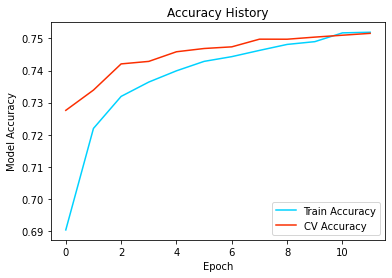

In [19]:
plt.plot(history['accuracy'], c='#00d2ff', label='Train Accuracy')
plt.plot(history['val_accuracy'], c='#fb2e01', label='CV Accuracy')
plt.title('Accuracy History')
plt.xlabel('Epoch')
plt.ylabel('Model Accuracy')
plt.legend()
plt.savefig('pics/accuracy_history.png')
#plt.show()

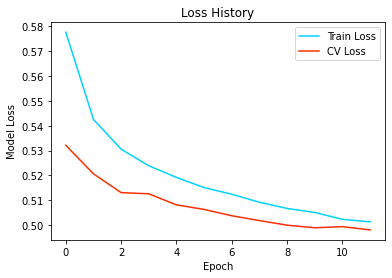

In [20]:
plt.plot(history['loss'], c='#00d2ff', label='Train Loss')
plt.plot(history['val_loss'], c='#fb2e01', label='CV Loss')
plt.title('Loss History')
plt.xlabel('Epoch')
plt.ylabel('Model Loss')
plt.legend()
plt.savefig('pics/loss_history.png')
#plt.show()

In [36]:
test = pd.read_csv("data/testdata.csv", encoding='ISO-8859-1', header=None, names=LABEL)
test = test[['Tweet', 'Sentiment']]
test.loc[test.Sentiment == 4, "Sentiment"] = 1
test.tail()

,Tweet,Sentiment
493,Ask Programming: LaTeX or InDesign?: submitted...,2
494,"On that note, I hate Word. I hate Pages. I hat...",0
495,Ahhh... back in a *real* text editing environm...,1
496,"Trouble in Iran, I see. Hmm. Iran. Iran so far...",0
497,Reading the tweets coming out of Iran... The w...,0


In [37]:
test = test[test['Sentiment'] < 2]
test.Sentiment.value_counts()

1    182
0    177
Name: Sentiment, dtype: int64

In [38]:
test['Tweet'] = test['Tweet'].apply(lambda col: clean_text(col))

In [39]:
test.tail()

,Tweet,Sentiment
492,use latex lot typeset mathemat look hideous,1
494,note hate word hate page hate latex said hate ...,0
495,ahhh back real text edit environ lt 3 latex,1
496,troubl iran see hmm iran iran far away flockof...,0
497,read tweet come iran whole thing terrifi incre...,0


In [53]:
tokenizer = pickle.load(open('processed_data/tokenizer_half.pyb', "rb"))
X_test = pad_sequences(tokenizer.texts_to_sequences(test.Tweet), maxlen = 40)
y_test = np.asarray(list(test.Sentiment))

In [42]:
pred = model.predict(X_test)

In [66]:
accuracy = np.mean(np.rint(pred) == y_test.reshape(-1, 1))
accuracy

0.8189415041782729

In [67]:
from sklearn.metrics import confusion_matrix
cm = confusion_matrix(y_true=y_test.reshape(-1, 1), y_pred=np.rint(pred))
cm

array([[137,  40],
       [ 25, 157]], dtype=int64)